In [229]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

CWD = os.getcwd()
DATA_DIR = os.path.join(CWD, 'data_files')

def plot_values_histogram(df:pd.DataFrame, column:str, title:str) -> None:
    ''' Plot a histogram of the values in a column of a dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to plot.
    column : str
        The column to plot.
    title : str
        The title of the plot.

    Returns
    -------
    None
    '''
    plt.figure(figsize=(10, 5))

    # Get total missing values for the column
    total = df[column].isnull().sum()

    # Get the proportion of missing values
    prop = round((total / len(df))*100,1)

    ax = df[column].value_counts().plot(kind='bar', title=title + f'   |   {total} missing value(s)   |   {prop}% missing')

    # Add labels to the bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

    # Formatting
    plt.ylabel('Count')
    plt.show()

### Missing Data

Addressing missing values is a critical aspect of data cleaning. Our aim is to identify and manage these gaps effectively while finding the right balance between imputation and removal. This step is all about completing the picture, ensuring our dataset is not just comprehensive but ready for robust analysis.

The first step to handling missing data is to check for missing values in each column. This initial step lays the foundation for effective data cleaning and paves the way for all future steps in the data cleaning process; It's essential to be rigorous and precise when approaching missing data! If missing values exist, a decision must be made regarding whether to fill in the gaps, referred to as imputation, or to remove the instances with missing data. This strategic choice influences the dataset's integrity, setting the direction for a tailored approach in handling missing values during the data cleaning process.

Although there is no exact definition of how to handle this decision, I like this advice proposed by Dr. Geetha Malika Nallamotu, a Data Scientist at IQVIA and Master of Professional Sciences in Biomedical and Health Informatics. She answered a question posed on LinkedIn; "How can you handle missing data in statistical software for ML?" by suggesting that missing data can be either imputed or removed based on a what proportion of values are missing:

- If missing values occur in less than 1% of the data, it is safe to remove or use basic imputation (mean/median).
- If missing values occur in 1%-5% of the data, it can be removed if random, otherwise, use simple imputation. 
- If missing values occur in 5%-20% of the data, be cautious about removal; Try advanced imputation.
- If missing values occur in 20%-50% of the data, avoid removing and consider using machine-learning imputation methods
- If missing values occur in greater than 50% of the data, consider exploring alternatives or consult domain experts to avoid bias.

Dr. Nallamotu's guidance creates a roadmap for navigating missing data. Her approach offers a spectrum of solutions that can provide flexibility for different situations. It not only provides practical thresholds for removal and imputation but also encourages a thoughtful consideration of advanced techniques and machine-learning-based approaches as the prevalence of missing values increases.

Now, let's apply the theory I have outlined at the beginning of this notebook using `data/imdb.csv`, which contains a small set of information about 88 movies.

In [230]:
# Load in data
imdb = pd.read_csv(os.path.join(DATA_DIR, 'imdb.csv'))

# Display a summary of the data
print('Summary:')
display(imdb.head())
shape = imdb.shape
print('Shape:', shape, sep='\n')

# List the number of null values in each column as a proportion of the total
null_vals = imdb.isnull().sum()
null_vals = null_vals[null_vals > 0]/shape[0] # Convert to proportion
null_vals = (null_vals * 100).round(1).astype(str) + '%' # Convert to percentage
print("\nColumns with null values:", null_vals, sep='\n')

Summary:


,director_name,duration,gross,genres,movie_title,title_year,language,country,budget,imdb_score,actors,movie_facebook_likes
0,Martin Scorsese,240,116866727.0,Biography|Comedy|Crime|Drama,The Wolf of Wall Street,2013,English,USA,100000000.0,8.2,"Leonardo DiCaprio,Matthew McConaughey,Jon Favreau",138000
1,Shane Black,195,408992272.0,Action|Adventure|Sci-Fi,Iron Man 3,2013,English,USA,200000000.0,7.2,"Robert Downey Jr.,Jon Favreau,Don Cheadle",95000
2,Quentin Tarantino,187,54116191.0,Crime|Drama|Mystery|Thriller|Western,The Hateful Eight,2015,English,USA,44000000.0,7.9,"Craig Stark,Jennifer Jason Leigh,Zoë Bell",114000
3,Kenneth Lonergan,186,46495.0,Drama,Margaret,2011,English,usa,14000000.0,6.5,"Matt Damon,Kieran Culkin,John Gallagher Jr.",0
4,Peter Jackson,186,258355354.0,Adventure|Fantasy,The Hobbit: The Desolation of Smaug,2013,English,USA,225000000.0,7.9,"Aidan Turner,Adam Brown,James Nesbitt",83000


Shape:
(88, 12)

Columns with null values:
gross     8.0%
genres    1.1%
budget    4.5%
dtype: object


We can see that the columns `gross`, `genres`, and `budget` contain various proportions of null values. Let's start our data cleaning journey from the smallest proportion.

`genres`:

The first step to cleaning a dataframe is to get a better idea of what a given column looks like. The function above called `plot_values_histogram()` will help us with that.

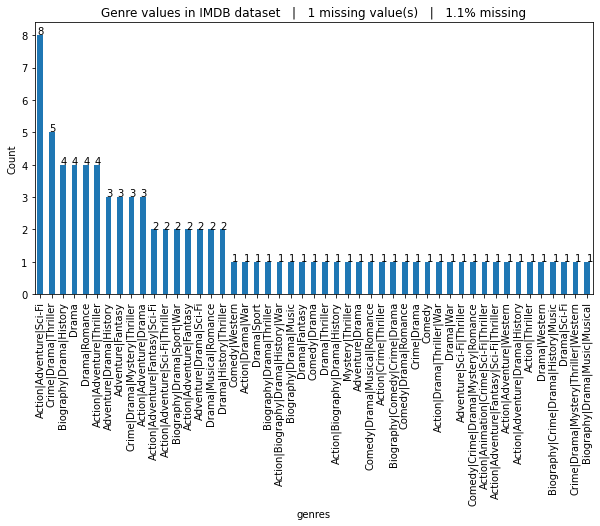

In [231]:
plot_values_histogram(imdb, 'genres', 'Genre values in IMDB dataset')

We can see that this column contains a wide variety of genres for each movie. Given our proportion of missing values being 1%, we can either remove or impute the value. Although an easy solution for this dataset would be to just look up what genres the movie is, this method isn't practical for larger amounts of null values, or datasets without any unique identifiers, like a movie title. For this feature, let's remove the missing value.

In [232]:
# Remove rows with null values in the genres column
imdb = imdb[imdb['genres'].notna()]

`budget` and `gross`:

These feature of the dataset indicates how much money was spent and made on a given movie, respectively. Let's inspect their values by looking at the distribution of data.

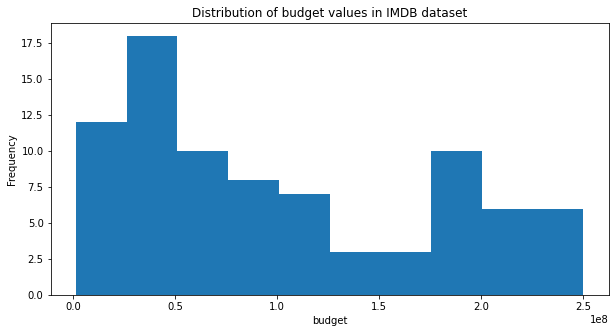

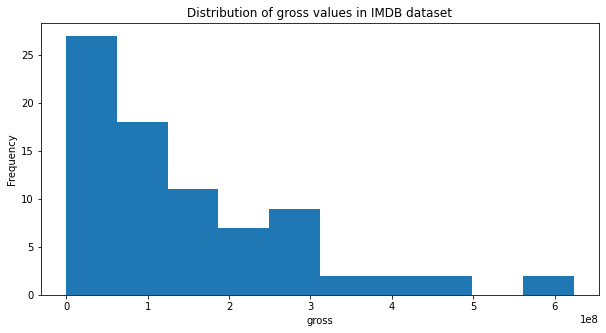

In [233]:
# Plot the distribution of budget values sorted from lowest to highest
for feature in ['budget', 'gross']:
    plt.figure(figsize=(10, 5))
    ax = imdb[feature].sort_values().plot(kind='hist', title=f'Distribution of {feature} values in IMDB dataset')
    plt.xlabel(feature)
    plt.title(f'Distribution of {feature} values in IMDB dataset')
    plt.show()

For these features, since our proportion of values is low enough, we can use simple imputation techniques to fill in our missing data.

For the `budget` feature, let's talk about what simple imputation methods exist. The 3 most basic are to use the Mean, Median, or Mode to replace missing values, or forward/backward fill for time-series data. Since we're working with categorical data, it makes the most sense to use either the mean, median, or mode.

Let's talk about which method would be appropriate for `budget`. First off, we notice that we have a small amount of right skew, and a relative balance in values across each range in the histogram. The mean sounds like a good choice here. The mean, or the average, is defined as: $$\bar x = \sum_{i=1}^{n}\frac{x_i}{n}$$ which means, add up each value in the dataset and divide it by the number of total values. This is a good choice because the mean is affected by outliers. Why is that? Well, let's look at a simple example. I have a dataset with 6 points: $1, 2, 3, 2, 1, 2$. The mean of these points is $$\bar x = \sum_{i=1}^{n}\frac{x_i}{n} = \frac{1+2+3+2+1 +2}{6} \approx 1.833$$ If we change one of these values to be an outlier, $1, 2, 3, 2, 1, 7$, our mean turns into $$\bar x = \sum_{i=1}^{n}\frac{x_i}{n} = \frac{1+2+3+2+1+7}{6} \approx 2.666$$

Now back to our movie dataset. Since we lack strong outliers, the mean makes sense here. If we had strong outliers, the value we would impute would be a higher value that would be not representative of the rest of the data points.

Imputing values at the mean value wouldn't change the spread of our distribution and would accurately represent the what we are trying to achieve. However, we see that the `gross` feature is right skewed, so using the median for imputation is a better strategy. The median is less sensitive to extreme values and provides a more robust measure of central tendency, making it suitable for skewed distributions.

In [234]:
# Impute missing budget values with the mean
imdb.loc[:, 'budget'] = imdb['budget'].fillna(imdb['budget'].mean())

# Impute missing gross values with the median
imdb.loc[:, 'gross'] = imdb['gross'].fillna(imdb['gross'].median())

In [235]:
# See how many missing values are left
print(imdb.isnull().sum())

director_name           0
duration                0
gross                   0
genres                  0
movie_title             0
title_year              0
language                0
country                 0
budget                  0
imdb_score              0
actors                  0
movie_facebook_likes    0
dtype: int64


And, we're done! Although there are many, many more steps in the data cleaning process, we've performed one of the most fundamental steps in the process. In the following paragraph, I have created a missing value cheat sheet. You can find Dr. Nallamotu's proportions, as well as some data imputation methods, including some we haven't discussed in this project.

<hr>

### Missing Value Cheat Sheet

#### Dr. Geetha Malika Nallamotu's proportions

- If missing values occur in less than 1% of the data, it is safe to remove or use basic imputation (mean/median).
- If missing values occur in 1%-5% of the data, it can be removed if random, otherwise, use simple imputation. 
- If missing values occur in 5%-20% of the data, be cautious about removal; Try advanced imputation.
- If missing values occur in 20%-50% of the data, avoid removing and consider using machine-learning imputation methods
- If missing values occur in greater than 50% of the data, consider exploring alternatives or consult domain experts to avoid bias.



#### Data imputation methods, in order of increasing complexity: 

- Mean/Median Imputation:
    - Replace missing values with the mean or median of the available values in that column.
    - Suitable for numerical data when the distribution is not heavily skewed.

- Mode Imputation:
    - For categorical data, replace missing values with the mode (most frequent value) of the respective column.

- Forward Fill (or Backward Fill):
    - Use the last known value to fill missing values. This is often suitable for time series data where values are ordered.

- Linear Regression Imputation:
    - Predict missing values using a linear regression model based on other features in the dataset.
    - Suitable for cases where there is a linear relationship between the variable with missing values and other variables.

- K-Nearest Neighbors (KNN) Imputation:
    - Impute missing values based on the values of k-nearest neighbors in the dataset.
    - Takes into account the similarity between observations.

- Multiple Imputation:
    - Generate multiple datasets with imputed values and analyze them separately.
    - Useful for accounting for uncertainty introduced by imputation.

- Interpolation Methods:
    - Use interpolation techniques such as linear or spline interpolation for time series data to estimate missing values based on existing values.

- Random Forest Imputation:

    - Use a random forest algorithm to predict missing values based on other features in the dataset.
    - Effective for both numerical and categorical data.

- Principal Component Analysis (PCA) Imputation:
    - Use PCA to identify patterns in the data and impute missing values based on principal components.

- Deep Learning Models:
    - Train deep learning models (e.g., neural networks) to predict missing values based on the available data.
    - Effective for complex relationships in high-dimensional datasets.